## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 2. Data Extraction

In [2]:
# Cargar datos
column_names = ["Timestamp", "Open", "High", "Low", "Close", "Volume"]
df = pd.read_csv("BTCUSDT.csv", names=column_names, header=None)

df["Timestamp"] = pd.to_numeric(df["Timestamp"], errors="coerce")
df = df[df["Timestamp"] > 1000000000]  # Filtrar valores irreales
if df["Timestamp"].max() > 10**12:
    df["Timestamp"] = df["Timestamp"] // 1000  # Convertir milisegundos a segundos
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s")

In [3]:
# Generar características
wz = 48  # Aumentar ventana a 48 horas para capturar mejor las tendencias
df["Price_Change"] = df["Close"] - df["Open"]
df["High_Low_Spread"] = df["High"] - df["Low"]
df["Pct_Change"] = df["Close"].pct_change()
df["Future_Close"] = df["Close"].shift(-1)

# Indicadores técnicos
df["SMA_10"] = df["Close"].rolling(window=10).mean()
df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()
df["Volatility"] = df["Close"].rolling(window=10).std()

In [4]:
# Reemplazar valores infinitos y NaN por valores válidos
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

df["Signal"] = np.where(df["Future_Close"] > df["Close"], 1, 0)

# Escalar datos
features = ["Open", "High", "Low", "Close", "Volume", "Price_Change", "High_Low_Spread", "Pct_Change", "SMA_10", "EMA_10", "Volatility"]
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Crear ventanas de datos
X, y = [], []
for i in range(len(df) - wz):
    X.append(df[features].iloc[i : i + wz].values)
    y.append(df["Signal"].iloc[i + wz])

X, y = np.array(X), np.array(y)

# Balancear clases con SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X.reshape(X.shape[0], -1), y)
X_resampled = X_resampled.reshape(X_resampled.shape[0], wz, len(features))

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

## 3. Construccion del modelo

In [5]:
# Construcción del modelo
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='gelu'))
model.add(Dense(1, activation='sigmoid'))

# Compilación y entrenamiento
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.5023 - loss: 0.6929 - val_accuracy: 0.5334 - val_loss: 0.6911
Epoch 2/20
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.5219 - loss: 0.6912 - val_accuracy: 0.5436 - val_loss: 0.6886
Epoch 3/20
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.5315 - loss: 0.6889 - val_accuracy: 0.5428 - val_loss: 0.6873
Epoch 4/20
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.5471 - loss: 0.6863 - val_accuracy: 0.5478 - val_loss: 0.6860
Epoch 5/20
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.5523 - loss: 0.6839 - val_accuracy: 0.5630 - val_loss: 0.6833
Epoch 6/20
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.5542 - loss: 0.6830 - val_accuracy: 0.5575 - val_loss: 0.6833
Epoch 7/20
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.5607 - loss: 0.6808 - val_accuracy: 0.5613 - val_loss: 0.6822
Epoch 8/20
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.5550 -

433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy en Test: 0.5734
F1-score en Test: 0.6131


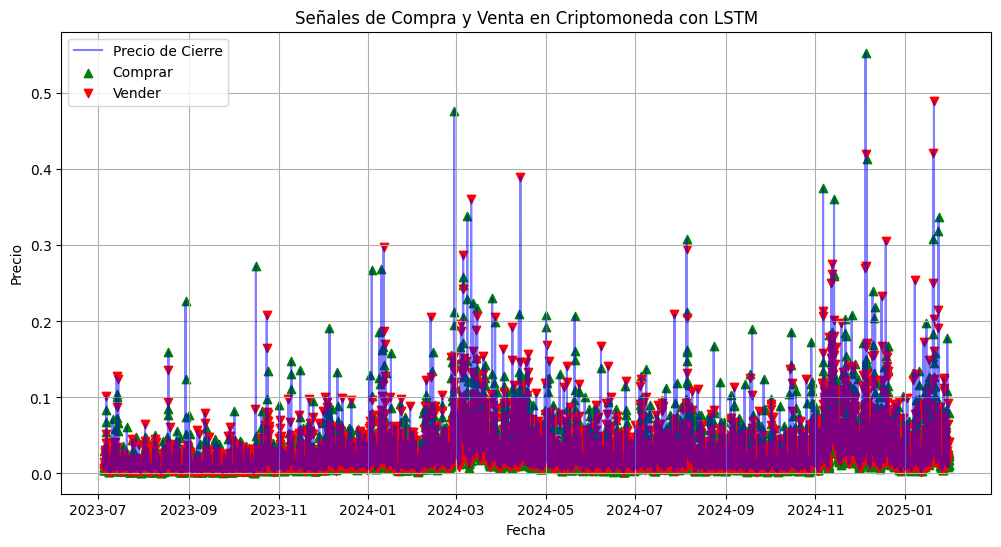

In [6]:
# Evaluación del modelo
y_pred = (model.predict(X_test) > 0.5).astype(int)
df_test = df.iloc[-len(y_test):].copy()
df_test["Prediction"] = y_pred.flatten()

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy en Test: {accuracy:.4f}")
print(f"F1-score en Test: {f1:.4f}")

# Visualización de predicciones
plt.figure(figsize=(12,6))
plt.plot(df_test["Timestamp"], df_test["Close"], label="Precio de Cierre", color="blue", alpha=0.5)

plt.scatter(df_test[df_test["Prediction"] == 1]["Timestamp"], df_test[df_test["Prediction"] == 1]["Close"],
            color="green", label="Comprar", marker="^", alpha=1)

plt.scatter(df_test[df_test["Prediction"] == 0]["Timestamp"], df_test[df_test["Prediction"] == 0]["Close"],
            color="red", label="Vender", marker="v", alpha=1)

plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Señales de Compra y Venta en Criptomoneda con LSTM")
plt.legend()
plt.grid()
plt.show()